### This notebook is designed for evaluating probabilistic time-series predictions

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '4'

import pickle
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from datetime import datetime
import matplotlib.pyplot as plt
import openai
openai.api_key = os.environ['OPENAI_API_KEY']
from data.serialize import serialize_arr, deserialize_str, SerializerSettings
from models.llmtime import get_llmtime_predictions_data
import torch


# Check if directory exists, if not create it
if not os.path.exists('plot_output'):
    os.makedirs('plot_output')

%load_ext autoreload
%autoreload 2

def plot_preds(train, test, pred_dict, model_name, show_samples=False):
    pred = pred_dict['median']
    pred = pd.Series(pred, index=test.index)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(train)
    plt.plot(test, label='Truth', color='black', alpha = 0.3)
    plt.plot(pred, label=model_name, color='purple')
    # shade 90% confidence interval
    samples = pred_dict['samples']
    lower = np.quantile(samples, 0.05, axis=0)
    upper = np.quantile(samples, 0.95, axis=0)
    plt.fill_between(pred.index, lower, upper, alpha=0.3, color='purple')
    if show_samples:
        samples = pred_dict['samples']
        # convert df to numpy array
        samples = samples.values if isinstance(samples, pd.DataFrame) else samples
        for i in range(min(10, samples.shape[0])):
            plt.plot(pred.index, samples[i], color='purple', alpha=0.15, linewidth=1)
    plt.legend(loc='upper left')
    if 'NLL/D' in pred_dict:
        nll = pred_dict['NLL/D']
        if nll is not None:
            plt.text(0.03, 0.85, f'NLL/D: {nll:.2f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    current_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    plt.savefig(f'plot_output/{current_time}.png')

    plt.show()
    



## Define models ##

In [2]:
llama_hypers = dict(
    alpha=0.99,
    beta=0.3,
    temp=float(0.5),
    basic=False,
    settings=SerializerSettings(base=10, prec=2, signed=True, time_sep=',', bit_sep='', minus_sign='-')
)

### from paper P17
# llama_hypers = dict(
#     alpha=0.99,
#     beta=0.3,
#     temp=float(0.5),
#     basic=False,
#     settings=SerializerSettings(base=10, prec=3, signed=True, time_sep=',', bit_sep='', minus_sign='-')
# )

gpt4_hypers = dict(
    alpha=0.3,
    basic=True,
    temp=1.0,
    top_p=0.8,
    settings=SerializerSettings(base=10, prec=3, signed=True, time_sep=',', bit_sep='', minus_sign='-')
)

### Default 
# gpt4_hypers = dict(
#     alpha=0.3,
#     basic=True,
#     temp=1.0,
#     top_p=0.8,
#     settings=SerializerSettings(base=10, prec=3, signed=True, time_sep=', ', bit_sep='', minus_sign='-')
# )

gpt3_hypers = dict(
    temp=0.7,
    alpha=0.95,
    beta=0.3,
    basic=False,
    settings=SerializerSettings(base=10, prec=3, signed=True, half_bin_correction=True)
)

### Default 
# gpt3_hypers = dict(
#     temp=0.7,
#     alpha=0.95,
#     beta=0.3,
#     basic=False,
#     settings=SerializerSettings(base=10, prec=3, signed=True, half_bin_correction=True)
# )


promptcast_hypers = dict(
    temp=0.7,
    settings=SerializerSettings(base=10, prec=0, signed=True, 
                                time_sep=', ',
                                bit_sep='',
                                plus_sign='',
                                minus_sign='-',
                                half_bin_correction=False,
                                decimal_point='')
)

arima_hypers = dict(p=[12,30], d=[1,2], q=[0])
model_hypers = {
    'LLMTime GPT-3.5': {'model': 'gpt-3.5-turbo-instruct', **gpt3_hypers},
    'LLMTime GPT-4': {'model': 'gpt-4', **gpt4_hypers},
    'LLMTime GPT-3': {'model': 'text-davinci-003', **gpt3_hypers},
    'PromptCast GPT-3': {'model': 'text-davinci-003', **promptcast_hypers},
    'ARIMA': arima_hypers,
    'llama-7b': {'model': 'llama-7b', **llama_hypers},
    'llama-13b': {'model': 'llama-13b', **llama_hypers},
    'llama-70b': {'model': 'llama-70b', **llama_hypers},
    
}

model_predict_fns = {
    # 'ARIMA': get_arima_predictions_data,
    # 'LLMTime GPT-3': get_llmtime_predictions_data,
    # 'LLMTime GPT-3.5': get_llmtime_predictions_data,
    # 'LLMTime GPT-4': get_llmtime_predictions_data,
    # 'PromptCast GPT-3': get_promptcast_predictions_data,
    'llama-7b': get_llmtime_predictions_data,
    # 'llama-13b': get_llmtime_predictions_data,
    # 'llama-70b': get_llmtime_predictions_data,
}


model_names = list(model_predict_fns.keys())


### Generate Dynamical_Systems Data

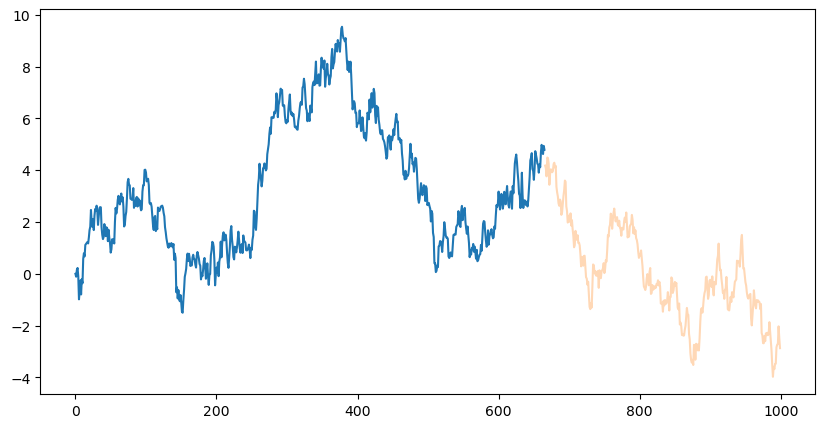

In [3]:
### Drift-Diffusion SDE

# Time discretization
Nt = 1000 # number of steps
dt =  0.2 # time step
tspan = np.linspace(0, Nt*dt, Nt)

# Drift and diffusion parameters
# Drift rate
# a = 0.3  
a = 0
# Noise level
sigma = 0.8

# Initialize the time series
X = np.zeros(Nt)
X[0] = 0  # Starting point
delta_x = []

np.random.seed(6)
# Generate the drift-diffusion time series
for t in range(1, Nt):
    dW =  np.random.normal()  # Wiener process (Brownian motion)
    dx = a * dt + sigma * np.sqrt(dt) * dW
    delta_x += [dx]
    X[t] = X[t-1] + dx

# Store the generated time-series in a pandas DataFrame
df = pd.DataFrame({'Time': tspan, 'X': X})

# Split the data into training and testing sets
train = df['X'][0:int(Nt/3*2)]
test = df['X'][int(Nt/3*2):]

plt.figure(figsize=(10, 5))
plt.plot(train, alpha = 1)
plt.plot([np.nan]*len(train)+list(test), alpha = 0.3)



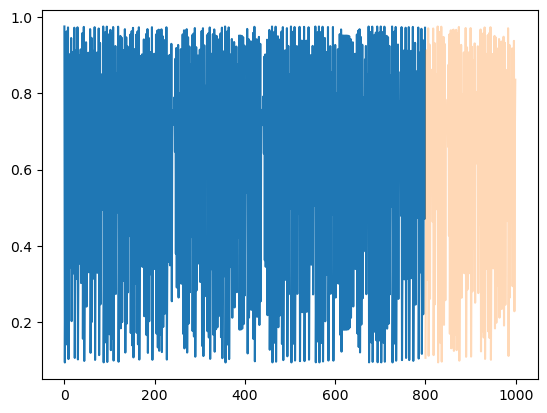

In [4]:
### Logistic Map
def logistic_map(r, x):
    return r * x * (1 - x)

# Parameters
r = 3.9  # Control parameter
x = 0.5  # Initial condition
Nt = 1000  # Number of iterations

time_series = []
for i in range(Nt):
    x = logistic_map(r, x)
    time_series.append(x)
    
df = pd.DataFrame({'X': time_series})
train = df['X'][0:int(Nt/5*4)]
test = df['X'][int(Nt/5*4):]

plt.plot(train, alpha = 1)
plt.plot([np.nan]*len(train)+list(test), alpha = 0.3)
plt.show()

### Running LLMTime and extracing logits

In [5]:
from jax import grad,vmap
def llama_nll_fn(model, input_arr, target_arr, settings:SerializerSettings, transform, count_seps=True, temp=1):
    """ Returns the NLL/dimension (log base e) of the target array (continuous) according to the LM 
        conditioned on the input array. Applies relevant log determinant for transforms and
        converts from discrete NLL of the LLM to continuous by assuming uniform within the bins.
    inputs:
        input_arr: (n,) context array
        target_arr: (n,) ground truth array
    Returns: NLL/D
    """
    model, tokenizer = get_model_and_tokenizer(model)

    input_str = serialize_arr(vmap(transform)(input_arr), settings)
    target_str = serialize_arr(vmap(transform)(target_arr), settings)
    full_series = input_str + target_str
    
    batch = tokenizer(
        [full_series], 
        return_tensors="pt",
        add_special_tokens=True
    )
    batch = {k: v.cuda() for k, v in batch.items()}

    with torch.no_grad():
        out = model(**batch)

    good_tokens_str = list("0123456789" + settings.time_sep)
    good_tokens = [tokenizer.convert_tokens_to_ids(token) for token in good_tokens_str]
    bad_tokens = [i for i in range(len(tokenizer)) if i not in good_tokens]
    out['logits'][:,:,bad_tokens] = -100
    # why not set to -inf?

    input_ids = batch['input_ids'][0][1:]
    logprobs = torch.nn.functional.log_softmax(out['logits'], dim=-1)[0][:-1]
    logprobs = logprobs[torch.arange(len(input_ids)), input_ids].cpu().numpy()

    tokens = tokenizer.batch_decode(
        input_ids,
        skip_special_tokens=False, 
        clean_up_tokenization_spaces=False
    )
    
    input_len = len(tokenizer([input_str], return_tensors="pt",)['input_ids'][0])
    input_len = input_len - 2 # remove the BOS token

    logprobs = logprobs[input_len:]
    tokens = tokens[input_len:]
    BPD = -logprobs.sum()/len(target_arr)

    #print("BPD unadjusted:", -logprobs.sum()/len(target_arr), "BPD adjusted:", BPD)
    # log p(x) = log p(token) - log bin_width = log p(token) + prec * log base
    transformed_nll = BPD - settings.prec*np.log(settings.base)
    avg_logdet_dydx = np.log(vmap(grad(transform))(target_arr)).mean()
    return transformed_nll-avg_logdet_dydx

### Convert time series to strings

In [6]:
from data.serialize import serialize_arr
X = np.append(train.values, test.values) 
settings = llama_hypers['settings']
rescale_factor = 1
# rescale_factor = 2
# rescale_factor = 0.3
rescale_factor = 0.8
rescaled_array = (X-X.min())/(X.max()-X.min())*rescale_factor+0.1
full_series = serialize_arr(rescaled_array, settings)

full_array = X

In [7]:
# rescale sigma
interval_sigma = sigma * np.sqrt(dt)/(X.max()-X.min()) * rescale_factor * settings.base ** settings.prec
interval_mean = a * dt/(X.max()-X.min()) * rescale_factor * settings.base ** settings.prec

In [8]:
full_series

'90,10,31,80,41,88,14,44,89,10,34,83,32,81,38,87,19,58,83,31,79,44,89,11,35,84,29,77,48,89,10,34,83,33,82,35,84,28,76,52,88,15,48,89,10,32,81,37,86,23,66,73,58,83,31,79,43,89,12,38,87,19,58,84,29,77,48,89,10,33,82,34,83,31,79,43,89,11,37,86,23,67,71,63,78,46,89,10,31,80,41,88,14,45,89,10,32,80,40,88,16,51,89,12,40,88,15,48,89,10,33,82,36,85,26,71,62,78,45,89,10,32,81,39,87,18,54,87,19,58,84,29,77,50,89,12,39,87,19,57,85,26,72,61,80,40,88,17,51,88,14,44,89,11,35,84,28,75,53,88,17,52,88,14,44,89,10,34,82,33,82,34,83,32,81,38,86,21,61,80,40,88,16,50,89,12,38,87,19,58,83,30,79,44,89,10,33,82,34,83,32,80,40,88,16,51,89,13,42,89,12,40,88,16,50,89,12,39,87,18,55,86,21,62,79,44,89,10,34,82,33,82,34,83,33,81,37,85,24,68,69,68,70,66,73,60,82,35,84,27,74,56,85,25,70,66,74,58,84,28,76,53,88,16,51,89,13,41,88,13,42,89,12,39,87,19,57,85,26,72,61,81,39,87,17,53,88,16,49,89,11,36,85,27,73,59,83,33,82,35,84,29,76,51,88,13,43,89,11,36,85,25,70,64,75,53,87,17,52,88,15,49,89,10,34,83,32,80,40,88,16,50,89,

### Compute Logits

In [9]:
import torch
torch.cuda.empty_cache()
from models.llama import get_model_and_tokenizer, get_tokenizer

model, tokenizer = get_model_and_tokenizer('13b')


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [18]:
batch = tokenizer(
        [full_series], 
        return_tensors="pt",
        add_special_tokens=True
    )
batch = {k: v.cuda() for k, v in batch.items()}
input_ids = batch['input_ids'][0][1:]

with torch.no_grad():
    out = model(**batch)
    

with open(f"plot_output/{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.pkl", 'wb') as f:
            pickle.dump(out['logits'], f)


In [10]:
# ### hand-serialized brownian motion 13b
# with open('plot_output/2023-11-16_14-39-59.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)
    
# ### hand-serialized brownian motion 13b, 0 drift
# with open('plot_output/2023-11-16_18-10-39.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)

# ### hand-serialized brownian motion 13b, 0 drift, prec=2
# with open('plot_output/2023-11-16_18-14-01.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)
    
### hand-serialized brownian motion 13b, 0 drift, prec=2, sigma = 0.8, seed = 6
# with open('plot_output/2023-11-17_03-24-00.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)

### hand-serialized brownian motion 13b, 0 drift, prec=2, sigma = 0.8, seed = 6, rescaled_max = 2
# with open('plot_output/2023-11-17_03-28-16.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)
    
### hand-serialized brownian motion 13b, 0 drift, prec=2, sigma = 0.8, seed = 6, rescaled_max = 0.3
# with open('plot_output/2023-11-17_03-33-54.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)

### hand-serialized logistic map, rescaled_max = 1
# with open('plot_output/2023-11-20_05-35-53.pkl', 'rb') as f:
#     logit_mat = pickle.load(f)
    
### hand-serialized logistic map, rescaled_max = 0.8
with open('plot_output/2023-11-20_05-38-30.pkl', 'rb') as f:
    logit_mat = pickle.load(f)
    
### Take out only the good tokens, which is equivalent to setting bad tokens to -inf
# good_tokens_str = list("0123456789" + settings.time_sep + settings.bit_sep)
good_tokens_str = list("0123456789")
good_tokens = [tokenizer.convert_tokens_to_ids(token) for token in good_tokens_str]
logit_mat = logit_mat[:,:,good_tokens]

### Visualize Softmax Prediction

In [30]:
### For probablistic series

from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.stats import norm

# Assuming logit_mat, T, good_tokens_str, full_array, and full_series are defined
# ...
# Temperature
T = 1
# discard first token
probs = torch.nn.functional.softmax(logit_mat[:,1:,:] / T, dim=-1)
string_labels = [label for label in good_tokens_str]
full_array_len = len(full_array)
good_tokens_len = len(good_tokens_str)

def digiprob_plotter(comma_idx=1):
    # Ensure comma_idx is within a valid range
    comma_idx = max(1, min(comma_idx, full_series.count(',') + 1))

    # Find the start and end indices of the value at the comma_idx-th comma
    comma_count = 0
    start_idx = None
    end_idx = None
    for i, char in enumerate(full_series):
        if char == ',':
            comma_count += 1
            if comma_count == comma_idx:
                start_idx = i + 1
            elif comma_count == comma_idx + 1:
                end_idx = i 
                break


    if start_idx is not None and end_idx is None:
        end_idx = len(full_series)

    # Calculate the number of digits to display in the softmax plot
    num_digits = end_idx - start_idx
    x_values = np.linspace(0, good_tokens_len, 300)
    mean = (interval_mean + rescaled_array[comma_idx-1])*10
    # print("mean", mean)
    sigma = interval_sigma/10
    gaussian = norm.pdf(x_values, mean, sigma)
    
    fig, axs = plt.subplots(2, 1, figsize=(12, 6))
    # Adjust the horizontal space between subplots
    plt.subplots_adjust(hspace=0.4)
    # Plot the full array with a marker on the selected value
    axs[0].plot(full_array, marker='o', color='black', markersize=3)
    axs[0].plot(comma_idx, full_array[comma_idx], color='r', marker='o')

    # Plot softmax distributions for each digit
    
    axs[1].set_xlabel("Digit")
    axs[1].set_ylabel("Probability Density")
    axs[1].set_title(full_series[start_idx-30:start_idx] + "?")
    
    for i in range(num_digits):
        digit_idx = start_idx + i

        
        if i == 0:
            x_label_coords = np.arange(good_tokens_len)
            x_coords = np.arange(good_tokens_len)+0.5            
            c = 'grey'
            w = 1
            probs_array = probs[:, digit_idx].cpu().numpy()[0]/1
            curr_digit = int(full_series[digit_idx])
            curr_digit_prob = probs_array[curr_digit]
            
            probs_array = np.delete(probs_array, curr_digit)
            x_coords = np.delete(x_coords, curr_digit)
            x_labels = np.delete(string_labels, curr_digit)
            x_label_coords = np.delete(x_label_coords, curr_digit)
            
            
        elif i == 1:
            previous_digit_prob = curr_digit_prob
            previous_digit = int(full_series[digit_idx-1])
            x_coords = np.linspace(previous_digit,previous_digit+1,good_tokens_len, endpoint = False)+0.05
            x_label_coords = np.concatenate((x_label_coords, 
                                             np.linspace(previous_digit,previous_digit+1,good_tokens_len, endpoint = False)
                                             ))
            x_labels = np.concatenate((x_labels, string_labels))
            c = 'black'
            w = 0.1
            probs_array = probs[:, digit_idx].cpu().numpy()[0]*previous_digit_prob/w
            
        
        axs[1].bar(x_coords, probs_array, color=c, width = w, label = 'prediction at digit ' + str(i+1))
        # axs[1].bar(x_coords, probs_array, color=c, width = w)

    axs[1].set_xticks(x_label_coords)
    axs[1].set_xticklabels(x_labels)
    axs[1].plot(x_values, gaussian, color = 'r', label = 'Truth')
    plt.legend()
    plt.show()

# Adjust the range of the slider to match the number of commas in the series
num_commas = full_series.count(',')
interact(digiprob_plotter, comma_idx=(0, num_commas, 1))

interactive(children=(IntSlider(value=1, description='comma_idx', max=1000), Output()), _dom_classes=('widget-…

<function __main__.digiprob_plotter(comma_idx=1)>

In [11]:
### For deterministic series

from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np
import torch

# Assuming logit_mat, T, good_tokens_str, full_array, and full_series are defined
# ...
# Temperature
T = 1
# discard first token
probs = torch.nn.functional.softmax(logit_mat[:,1:,:] / T, dim=-1)
string_labels = [label for label in good_tokens_str]
full_array_len = len(full_array)
good_tokens_len = len(good_tokens_str)

def digiprob_plotter(comma_idx=1):
    # Ensure comma_idx is within a valid range
    comma_idx = max(1, min(comma_idx, full_series.count(',') + 1))

    # Find the start and end indices of the value at the comma_idx-th comma
    comma_count = 0
    start_idx = None
    end_idx = None
    for i, char in enumerate(full_series):
        if char == ',':
            comma_count += 1
            if comma_count == comma_idx:
                start_idx = i + 1
            elif comma_count == comma_idx + 1:
                end_idx = i 
                break


    if start_idx is not None and end_idx is None:
        end_idx = len(full_series)

    # Calculate the number of digits to display in the softmax plot
    num_digits = end_idx - start_idx
    truth = int(full_series[start_idx:end_idx ])
    # print('truth', truth)
    
    fig, axs = plt.subplots(2, 1, figsize=(12, 6))
    # Adjust the horizontal space between subplots
    plt.subplots_adjust(hspace=0.4)
    # Plot the full array with a marker on the selected value
    axs[0].plot(full_array, marker='o', color='black', markersize=3, lw = '0.1')
    axs[0].plot(comma_idx, full_array[comma_idx], color='r', marker='o')

    # Plot softmax distributions for each digit
    
    axs[1].set_xlabel("Digit")
    axs[1].set_ylabel("Probability Density")
    axs[1].set_title(full_series[start_idx-30:start_idx] + "?")
    
    for i in range(num_digits):
        digit_idx = start_idx + i

        
        if i == 0:
            x_label_coords = np.arange(good_tokens_len)
            x_coords = np.arange(good_tokens_len)+0.5            
            c = 'grey'
            w = 1
            probs_array = probs[:, digit_idx].cpu().numpy()[0]/1
            curr_digit = int(full_series[digit_idx])
            curr_digit_prob = probs_array[curr_digit]
            
            probs_array = np.delete(probs_array, curr_digit)
            x_coords = np.delete(x_coords, curr_digit)
            x_labels = np.delete(string_labels, curr_digit)
            x_label_coords = np.delete(x_label_coords, curr_digit)
            
            
        elif i == 1:
            previous_digit_prob = curr_digit_prob
            previous_digit = int(full_series[digit_idx-1])
            x_coords = np.linspace(previous_digit,previous_digit+1,good_tokens_len, endpoint = False)+0.05
            x_label_coords = np.concatenate((x_label_coords, 
                                             np.linspace(previous_digit,previous_digit+1,good_tokens_len, endpoint = False)
                                             ))
            x_labels = np.concatenate((x_labels, string_labels))
            c = 'black'
            w = 0.1
            probs_array = probs[:, digit_idx].cpu().numpy()[0]*previous_digit_prob/w
            
        
        axs[1].bar(x_coords, probs_array, color=c, width = w, label = 'prediction at digit ' + str(i+1))
        # axs[1].bar(x_coords, probs_array, color=c, width = w)

    axs[1].set_xticks(x_label_coords)
    axs[1].set_xticklabels(x_labels)
    axs[1].vlines(truth/10, 0, 7, color = 'r', label = 'Truth', lw = 3)
    plt.legend()
    plt.show()

# Adjust the range of the slider to match the number of commas in the series
num_commas = full_series.count(',')
interact(digiprob_plotter, comma_idx=(0, num_commas, 1))

interactive(children=(IntSlider(value=1, description='comma_idx', max=1000), Output()), _dom_classes=('widget-…

<function __main__.digiprob_plotter(comma_idx=1)>

### Compare with NLL

In [11]:
good_tokens_str = list("0123456789" + settings.time_sep + settings.bit_sep)
good_tokens = [tokenizer.convert_tokens_to_ids(token) for token in good_tokens_str]
bad_tokens = [i for i in range(len(tokenizer)) if i not in good_tokens]
logit_mat[:,:,bad_tokens] = -np.inf

In [12]:
logit_mat

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [13]:
logprobs = torch.nn.functional.log_softmax(logit_mat, dim=-1)[0][:-1]
# logprob of the full trajectory
logprobs = logprobs[torch.arange(len(input_ids)), input_ids].cpu().numpy()
NLL = -logprobs

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


---

In [16]:
char_array = np.array(list(full_series))
comma_locations = np.where(char_array == ',')[0][:-1]

NLL_digit = -logprobs[comma_locations+1-2]

NameError: name 'logprobs' is not defined

In [17]:
window_size = 30

top_hat_kernel = np.ones(window_size) / window_size
averaged_loss = np.convolve(NLL_digit, top_hat_kernel, mode='valid')
plt.figure(figsize=(10, 6))
plt.plot(NLL_digit, label="Original Loss", alpha=0.7, c = 'black')
plt.plot(np.arange(window_size//2, len(NLL_digit) - window_size//2 + 1), averaged_loss, label="Averaged Loss", linewidth=2, c = 'blue')
plt.xlabel("Context length")
plt.ylabel("Averaged NLL")
# plt.loglog()

NameError: name 'NLL_digit' is not defined